In [1]:
import numpy as np
import pandas as pd
from ord_data_load import ORD_PATH, df_na_vals, fahrenheit_to_celsius
from chem_render import draw_reaction

from matplotlib import pyplot as plt

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%load_ext autoreload
%autoreload 2

# 1. Inspect REACTIONS dataset

In [4]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1079502 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-50ff38288a5a4316959b81c266f6f624
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   rxn_smiles    1079502 non-null  object  
 1   time          533564 non-null   float64 
 2   temp          264429 non-null   float64 
 3   temp_control  268657 non-null   category
 4   yield         441568 non-null   float64 
 5   patent        1079502 non-null  category
 6   notes         1079502 non-null  object  
 7   c_ratio       1079502 non-null  float64 
dtypes: category(2), float64(4), object(2)
memory usage: 63.8+ MB
CPU times: total: 4 s
Wall time: 4 s


## 1.1 SMILES

In [3]:
print("Fraction of unique reaction smiles:")
df.rxn_smiles.unique().shape[0] / df.shape[0]

Fraction of unique reaction smiles:


0.6111673085601422

In [4]:
print("Fraction of unique reaction notes:")
df.notes.unique().shape[0] / df.shape[0]

Fraction of unique reaction notes:


0.7562103829164273

In [5]:
dups = df.duplicated(subset=['rxn_smiles'])
dup_smi = df.loc[dups, 'rxn_smiles'].unique()
dup_smi

array(['[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16]>CO>[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16].[CH3:3][OH:4] |f:3.4.5|',
       '[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Na+].[Na+].[Na+].[Cl-].[Ca+2:10].[Cl-]>O>[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Ca+2:10].[Ca+2:10].[Ca+2:10].[P:1]([O-:5])([O-:4])([O-:3])=[O:2] |f:0.1.2.3,4.5.6,8.9.10.11.12|',
       '[CH3:1][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[CH:10]=1)(=[O:8])=[O:7])([CH3:4])[CH3:3].C([Li])CCC.Cl[C:21]([O:23][CH3:24])=[O:22].Cl>C1COCC1.[Au]>[CH3:4][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[C:10]=1[C:21]([O:23][CH3:24])=[O:22])(=[O:8])=[O:7])([CH3:1])[CH3:3]',
       ...,
       '[Li]CCCC.Br[C:7]1[CH:8]=[CH:9][C:10]([O:13][CH2:14][CH2:15][O:16][C:17]2[C:22]([Cl:23])=[CH:21][C:20]([CH3:24])=[CH:19][C:18]=2[Cl:25])=[N:11][CH:12]=1.[CH3:26][O:27][

In [6]:
# inspect duplicates
from random import choice

df.loc[df.rxn_smiles == choice(dup_smi)]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-0a3f192e74d04953a05aecbbc62a31ec,[CH3:1][C:2]1([CH3:24])[C:11]([CH3:13])([OH:12...,NaN,NaN,NaN,NaN,NaN,NaN,US05387587,"A mixture of 327 mg of 2,2,3-trimethyl-4-(1,6-..."
ord-1e37b3dbef4844239f9bb7debe6e3856,[CH3:1][C:2]1([CH3:24])[C:11]([CH3:13])([OH:12...,NaN,NaN,NaN,NaN,NaN,NaN,US06040308,"A mixture of 327 mg of 2,2,3-trimethyl-4-(1,6-..."
ord-aaaed00589654e34b0efc5cfaa2a93e4,[CH3:1][C:2]1([CH3:24])[C:11]([CH3:13])([OH:12...,NaN,NaN,NaN,NaN,NaN,NaN,US06153627,"A mixture of 327 mg of 2,2,3-trimethyl-4-(1,6-..."
ord-f92cb193811a4eccaed3571074960bcb,[CH3:1][C:2]1([CH3:24])[C:11]([CH3:13])([OH:12...,NaN,NaN,NaN,NaN,NaN,NaN,US05013853,"A mixture of 327 mg of 2,2,3-trimethyl-4-(1,6-..."


### drop duplicated smiles
we can safely drop duplicated smiles as almost all the reactions are identical in terms of parsed fields

In [7]:
%%time
df.drop_duplicates(subset=['rxn_smiles'], inplace=True)

CPU times: total: 859 ms
Wall time: 876 ms


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082098 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-50ff38288a5a4316959b81c266f6f624
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   rxn_smiles    1082098 non-null  object  
 1   time_unit     534242 non-null   category
 2   time_val      534242 non-null   float64 
 3   temp_unit     264938 non-null   category
 4   temp_val      264938 non-null   float64 
 5   temp_control  268837 non-null   category
 6   yield         441806 non-null   float64 
 7   patent        1082098 non-null  category
 8   notes         1082098 non-null  object  
dtypes: category(4), float64(3), object(2)
memory usage: 57.8+ MB


## 1.2 Time

In [9]:
df.time_unit.value_counts(dropna=False)

NaN       547856
HOUR      399554
MINUTE    121659
DAY        12749
SECOND       280
Name: time_unit, dtype: int64

280


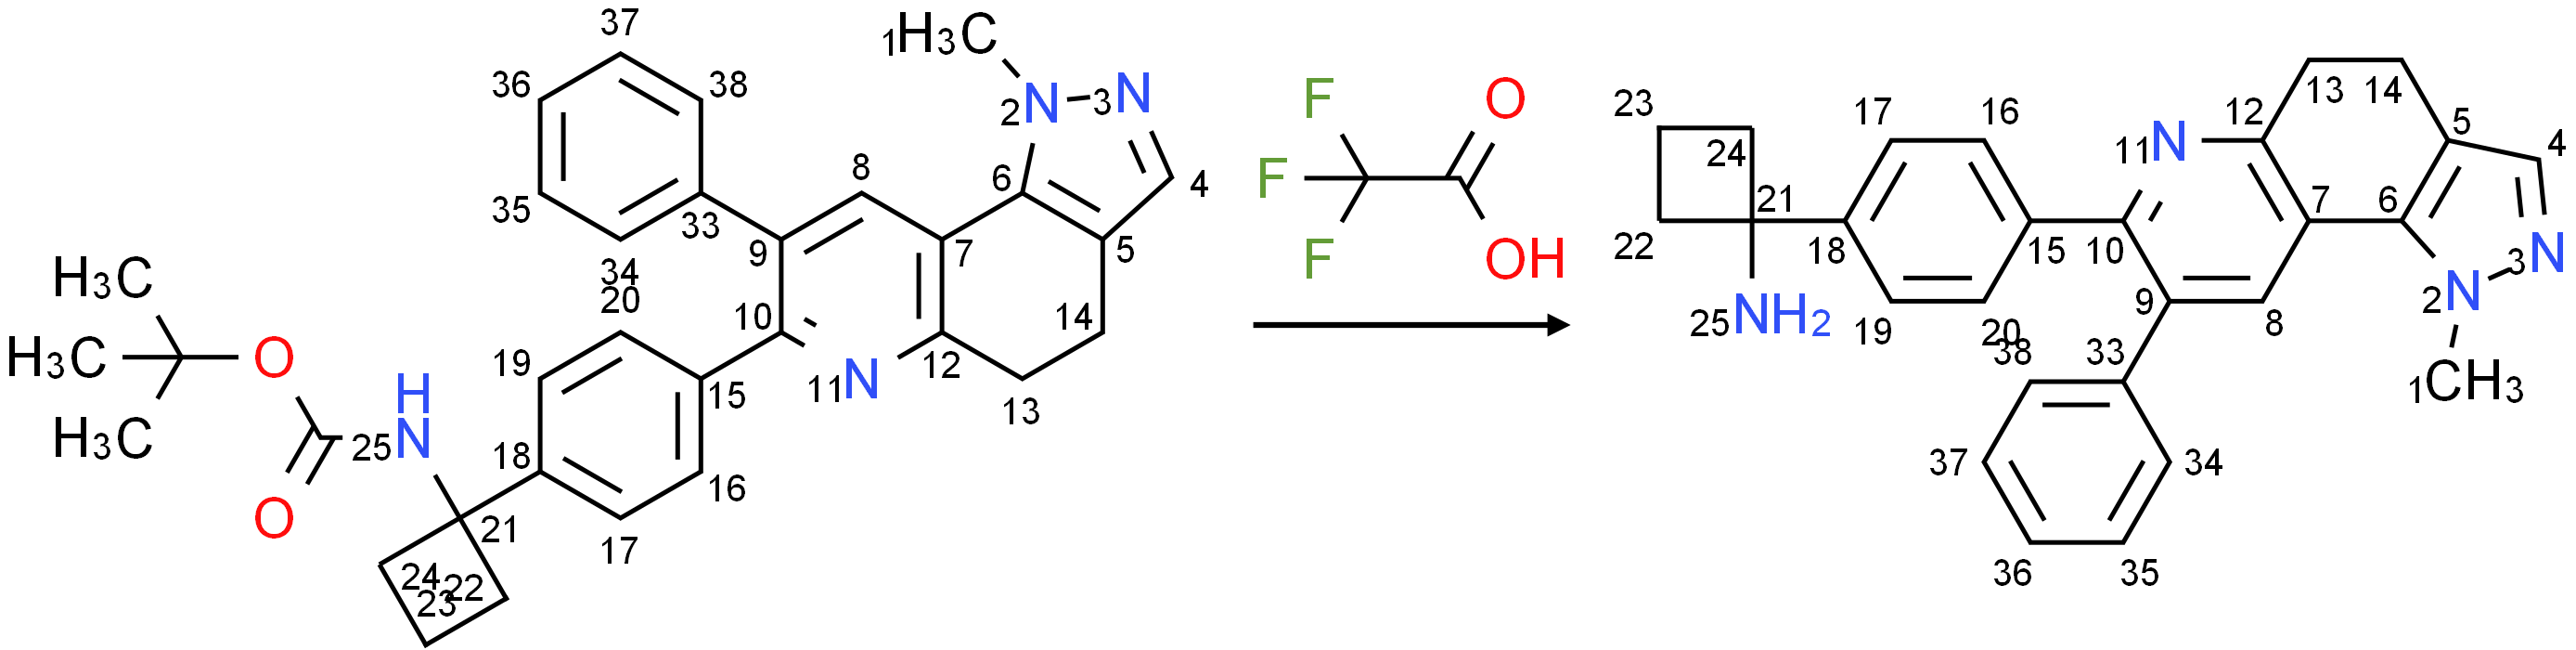

Set size:         280
Patent:           US09221838B2
Reaction_id:      ord-4557d447323d47e08634ee743da4a434
Tert-butyl (1-(4-(1-methyl-8-phenyl-4,5-dihydro-1H-pyrazolo[3,4-f]quinolin-7-yl)phenyl)cyclobutyl)carbamate (3 mg, 0.006 mmol) was dissolved in TFA (0.5 mL) and stirred for 30 seconds. The solution was immediately concentrated to dryness under reduced pressure. The residue was dissolved in diethyl ether (˜1 mL) and concentrated to dryness under reduced pressure three times. The residue was then slurried in diethyl ether (1 mL) and after settling the supernatant solvent removed by pipette. This was repeated three times. The remaining solvent was removed under reduced pressure and dried to give the desired product as an off-white solid (0.65 mg, 22% yield). 1H NMR (500 MHz, CH3OD) 8.06 (s, 1H), 7.50 (d, 2H), 7.43 (d, 3H), 7.27-7.36 (br m, 5H), 4.19 (s, 1H), 3.22 (t, 2H), 2.93 (t, 2H), 2.73-2.83 (br m, 2H), 2.54-2.66 (br m, 2H), 2.18-2.33 (br m, 1H), 1.92-2.03 (br m, 1H). LCMS (Meth

In [10]:
# seconds
print((df.time_unit == 'SECOND').sum())
draw_reaction(df[df.time_unit == 'SECOND'])

In [11]:
# convert time to HOURS

mask = df.time_unit == 'SECOND'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 3600

mask = df.time_unit == 'MINUTE'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 60

mask = df.time_unit == 'DAY'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] * 24

In [12]:
df.time_val.describe()

count    534242.000000
mean          8.464771
std          19.339936
min           0.000000
25%           1.000000
50%           2.500000
75%           8.000000
max        2160.000000
Name: time_val, dtype: float64

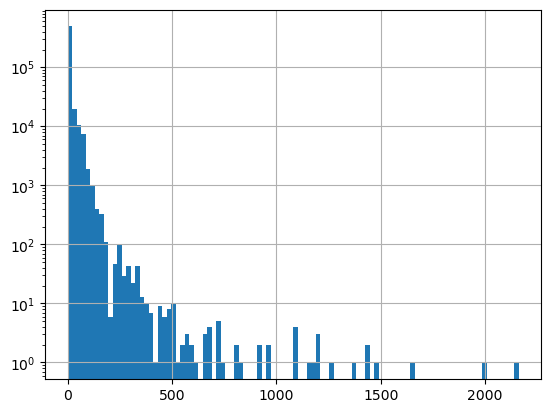

In [13]:
df.time_val.hist(bins=100)
plt.yscale('log')

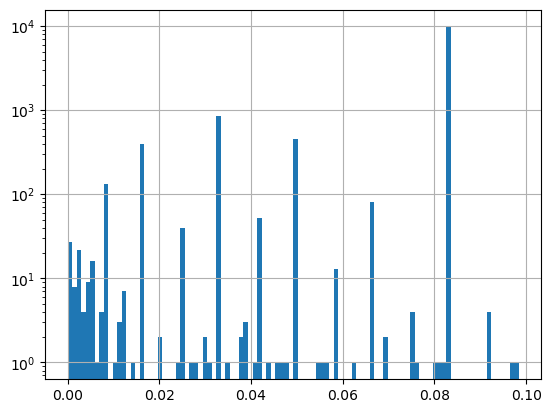

In [14]:
# inspect outliers
df[df.time_val < 0.1].time_val.hist(bins=100)
plt.yscale('log')

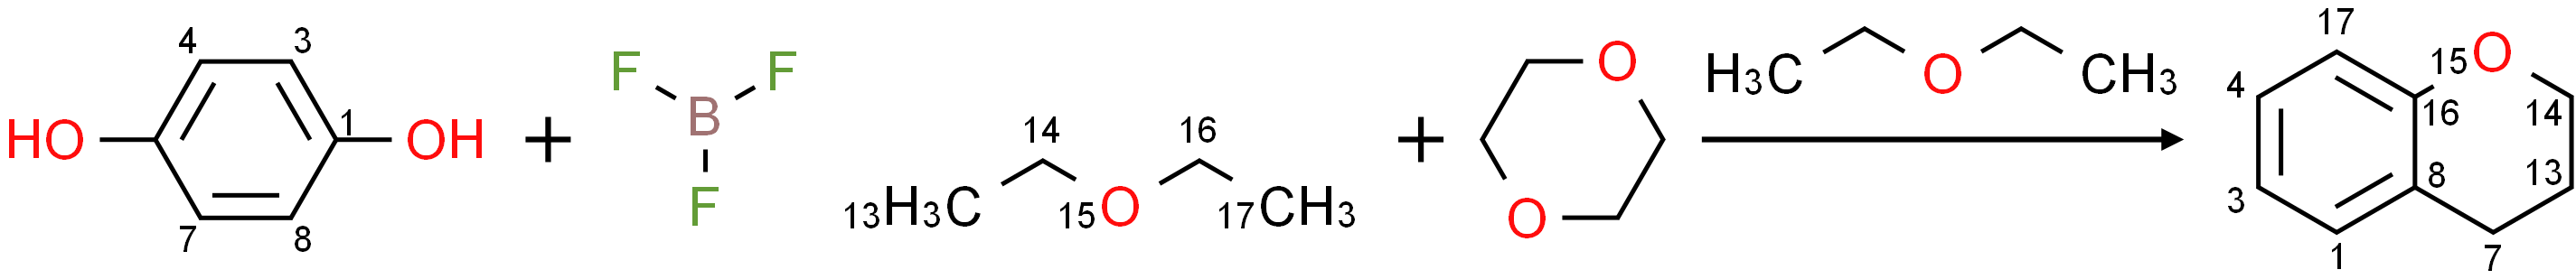

Set size:         8
Patent:           US06242479B1
Reaction_id:      ord-009af41175954de8b17b12067996214f
To a solution of hydroquinone 1 (0.01 mol) and a catalyst, preferably boron trifluoride diethyl etherate (0.016 mol) In an organic solvent, preferably dry dioxane (10 mL), is added vinyl lactone 2 (0.016 mol) in an organic solvent, preferably dry dioxane (5.0 mL) over 1-60 minutes, preferably 60 minutes, at 0-150° C., preferably 110° C., under an inert gas. The reaction mixture is stirred for 0 to 8 hours, preferably 0 hours, at the selected temperature, cooled to room temperature, and diluted with an organic solvent, preferably diethyl ether (200 mL) The reaction mixture is then washed with water (100 mL, 2×50 mL), dried over sodium sulfate (Na2SO4), and solvent is removed under reduced pressure to afford a brown oily residue. The residue is dissolved in alcohol, preferably methanol (30 mL), and the alcohol is then removed under reduced pressure. The brown oily liquid or semisolid

In [15]:
draw_reaction(df[df.time_val == 0.0])

In [16]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [17]:
# reset to NaN time == 0.0
mask = df.time_val == 0.0
df.loc[mask, 'time_val'] = np.nan
df.loc[mask, 'time_unit'] = np.nan
df[mask]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-f52e0b391d5149ee916861578ec96bce,[C:1]([O:5][C:6]([N:8]([C:16]1[C:21]([CH3:23])...,NaN,NaN,CELSIUS,-78.0,NaN,NaN,US09309263B2,To a dry flask was added tert-butyl N-tert-but...
ord-77e3cb06d0a7449cb448a45cdf4b3003,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.[B]....,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of hydroquinone 1 (0.01 mol) and...
ord-91345a02d0c34481b59b0d84a51a4ac6,[C:1]1(O)[CH:6]=[CH:5]C=[CH:3][CH:2]=1.B(F)(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of phenol 4 (0.01 mol) and a cat...
ord-20f38895a7c74d7ea9f6c9b0bd5016c0,[NH2:1][CH:2]1[C:19](=[O:20])[N:4]2[C:5]([C:16...,NaN,NaN,NaN,NaN,AMBIENT,66.199997,US04959495,"A mixture of 7-amino-3-[(1,2,3-thiadiazol-5-yl..."
ord-009af41175954de8b17b12067996214f,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.B(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06242479B1,To a solution of hydroquinone 1 (0.01 mol) and...
ord-a72a83f17a1c4019962f740a6dd9f504,O1CCCC1.[C:6]([O:11][Si](C)(C)C)(=[O:10])[C:7]...,NaN,NaN,NaN,NaN,NaN,NaN,US05250109,A block copolymer of n-butyl methacrylate and ...
ord-4b6a554e34344e9587f0cb61a4875414,[C:1]1([C:32]2[CH:37]=[CH:36][CH:35]=[CH:34][C...,NaN,NaN,NaN,NaN,NaN,86.000000,US08158634B2,A solution of 2-biphenyl-4-yl-8-bromomethyl-1-...
ord-c4e60a15534d41d5931aeb64a309d73b,[C:1]([S:4][CH2:5][CH2:6][NH:7][C:8](=[O:51])[...,NaN,NaN,NaN,NaN,NaN,NaN,US07754455B2,S-acetyl CoA synthetase (acetate thiokinase fr...


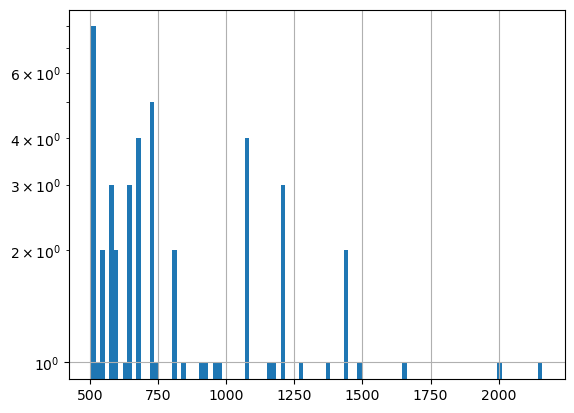

In [18]:
df.loc[df.time_val > 500, 'time_val'].hist(bins=100)
plt.yscale('log')

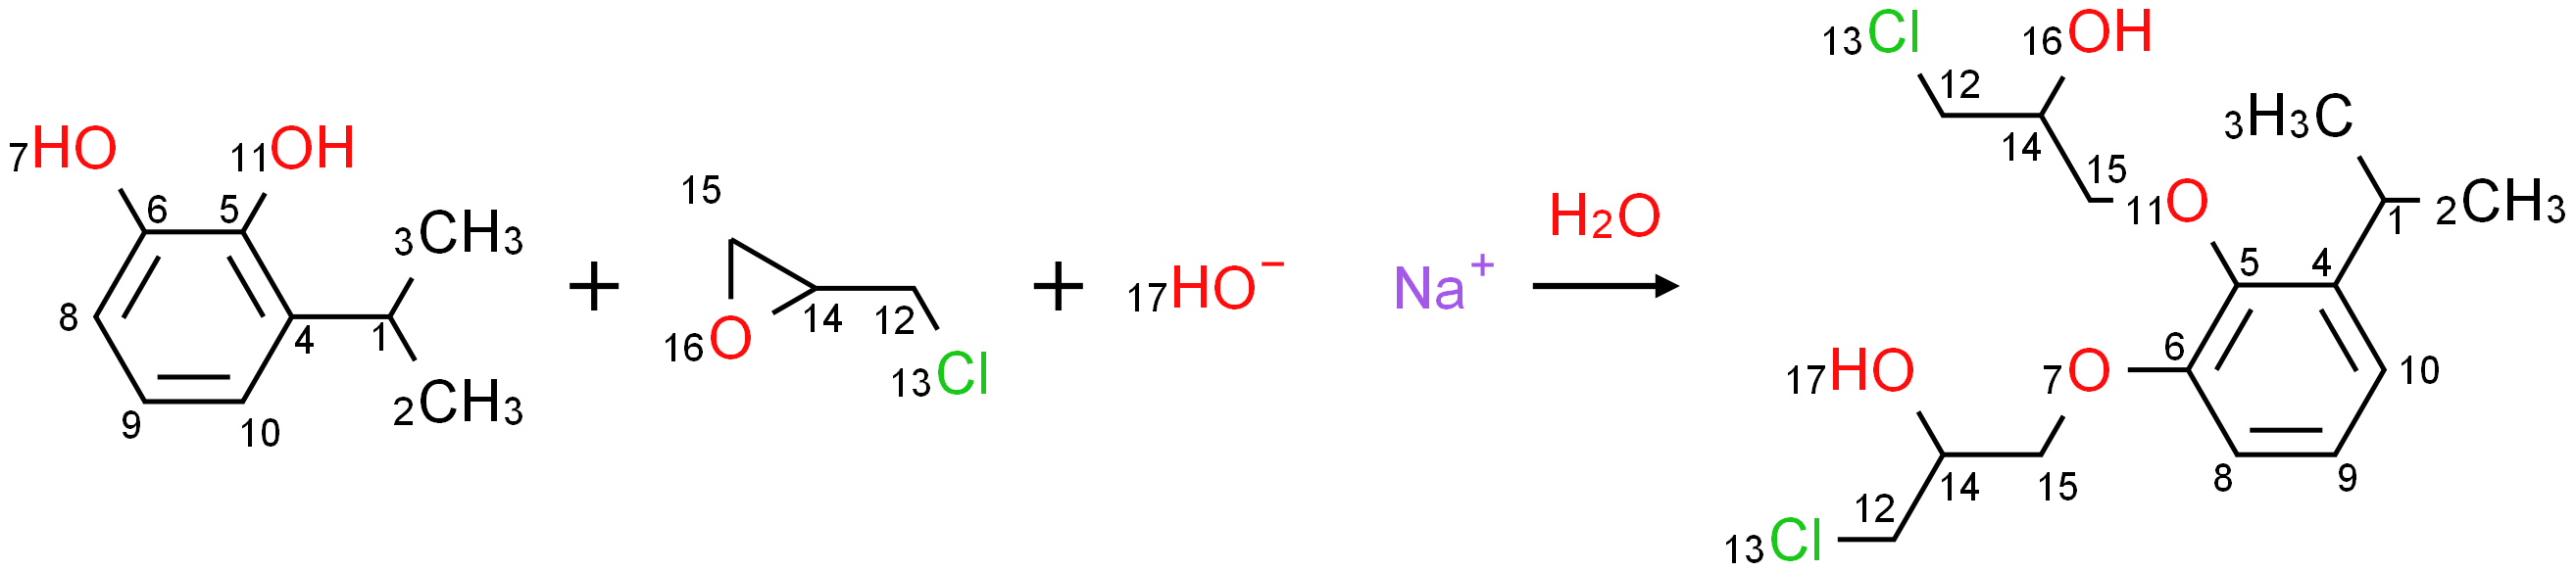

Set size:         54
Patent:           US03998874
Reaction_id:      ord-b0447b2b57c04281a759f36bbb7b6117
22.9 g. of 3-isopropylcatechol, 56 g. of epichlorhydrin and 0.2 g. of sodium hydroxide, dissolved in a few drops of water, are stirred together for 21 days at 40° C under a nitrogen atmosphere. The excess of epichlorohydrin is distilled off under reduced pressure. The resulting oil is dissolved in chloroform, washed twice with water and purified by molecular distillation at 10-3 mm.Hg 32.55 g. of impure 1,1'-[(3-isopropyl-o-phenylene)dioxy]-bis-(3-chloropropan-2-ol) are obtained.


In [19]:
draw_reaction(df[df.time_val > 500])

In [20]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [21]:
# rename time 'column' and drop 'time_unit'
df.rename(columns={'time_val': 'time'}, inplace=True)
df.drop(columns='time_unit', inplace=True)
df

,rxn_smiles,time,temp_unit,temp_val,temp_control,yield,patent,notes
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ..."
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ..."
...,...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


## 1.3 Temperature

In [22]:
df.temp_unit.value_counts()

CELSIUS       264876
FAHRENHEIT        57
KELVIN             5
Name: temp_unit, dtype: int64

In [39]:
mask = df.temp_unit == 'FAHRENHEIT'
id = 'ord-85dfea9f3f584c14b1e94a4cc00b506b'
df.loc[id, 'temp_val'], df.loc[mask, 'temp_val'].apply(fahrenheit_to_celsius)[id]

(230.0, 110.0)

In [43]:
mask = df.temp_unit == 'KELVIN'
df.loc[mask, 'temp_val'].apply(lambda x: x - 273.15)

ord-071609ac54774c9b8e0213c8ba4f29ff    99.85
ord-1999d9fe28034792b4b9767334223317    69.85
ord-0538fba1fd7449b78489339e8cd5fbae    69.85
ord-966a6a6fb3bf4862a268ad3bb904838c     3.35
ord-0a4ef40c7a5c499283d3f3949240aca0    49.85
Name: temp_val, dtype: float64

In [44]:
# convert everything to CELSIUS
mask = df.temp_unit == 'FAHRENHEIT'
df.loc[mask, 'temp_val'] = df.loc[mask, 'temp_val'].apply(fahrenheit_to_celsius)

mask = df.temp_unit == 'KELVIN'
df.loc[mask, 'temp_val'] = df.loc[mask, 'temp_val'].apply(lambda x: x - 273.15)

In [45]:
# rename time 'column' and drop 'time_unit'
df.rename(columns={'temp_val': 'temp'}, inplace=True)
df.drop(columns='temp_unit', inplace=True)
df

,rxn_smiles,time,temp,temp_control,yield,patent,notes
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ..."
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ..."
...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


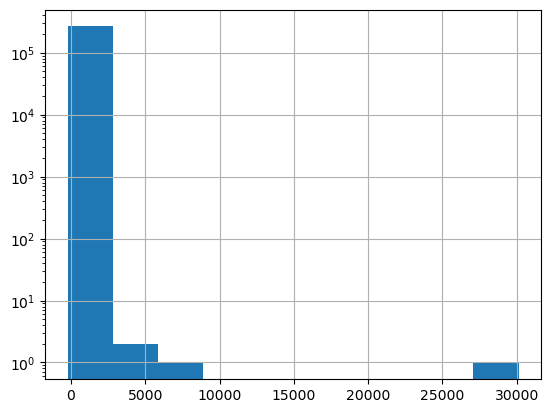

In [47]:
df.temp.hist(bins=10)
plt.yscale('log')

In [50]:
df.loc[df.temp > 25000, 'notes'].iat[0]

'1-(2-bromoethoxy)-3-fluoro-5-methylsulfonyl-benzene (0.5 g, 1.6 mmol), azetidine (0.23 ml, 3.2 mmol) and potassium carbonate (0.58 g, 4.2 mmol) was dissolved in acetonitrile (10 ml). The mixture was heated in a sealed container at 30120° C. for 2 h. The reaction mixture was cooled to room temperature, CH2Cl2 (100 ml) was added, solids was filtered off and the volatiles were evaporated. The amine was converted to the fumaric acid salt and re-crystallized from methanol/diethyl ether. MS m/z (relative intensity, 70 eV) 273 (M+, 1), 94 (5), 82 (3), 71 (5), 70 (bp).'

In [51]:
# search original patent, temperature was 120°C
df.loc[df.temp > 25000, 'temp'] = 120.0

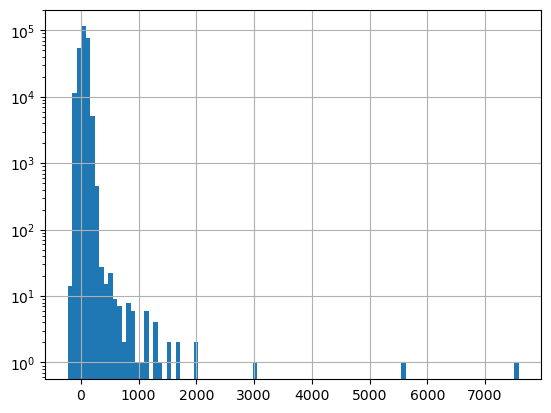

In [52]:
df.temp.hist(bins=100)
plt.yscale('log')

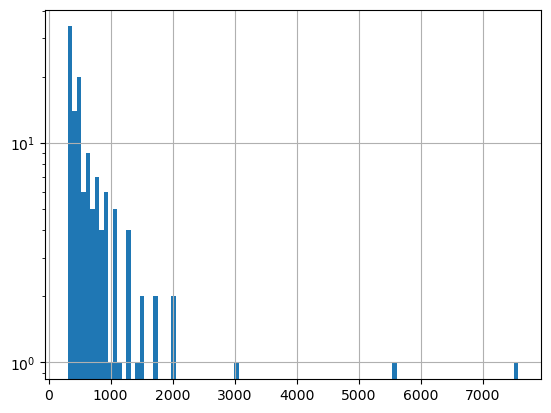

In [76]:
df.loc[df.temp > 300, 'temp'].hist(bins=100)
plt.yscale('log')

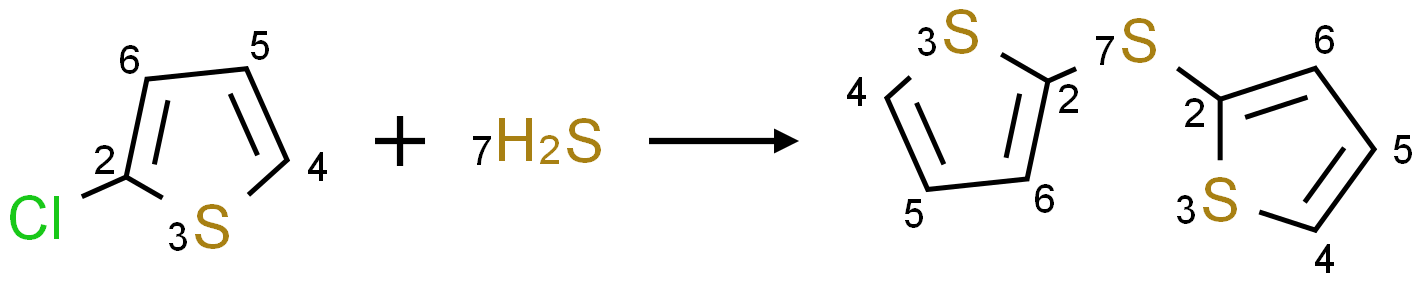

Set size:         58
Patent:           US04010210
Reaction_id:      ord-3d271068c6d14c168cd3aa3af3ac1456
Through a 570-mm long silica tube, 26 mm in diameter, heated to a temperature of 560° C, for 90 minutes are passed 40.0 g (0.34 mole) of 2-chlorothiophene and hydrogen sulphide at a rate of 5.2 litres per hour. The molar ratio of 2-chlorothiophene to hydrogen sulphide is 1:1. The condensate is distilled to give 16 g (48.2 percent by weight) of di(2-thienyl) sulphide boiling at 133°-140° C (5 mm Hg), nD20 = 1.6603, and 6.5 g of the starting 2-chlorothiophene (conversion 84 percent by weight).


In [337]:
rxn_id = draw_reaction(df[df.temp > 500], highlight_text="° C")

In [338]:
# Temperatures 250 - 500°C seem still to be sometimes present.
# Temperatures higher than most organic reactions and should be divided by 10.
# or it can be pyrolysis, but then this reaction type is of no interest to us.
mask = df.temp > 500
df.loc[mask, 'temp'] = df.loc[mask, 'temp'] / 10

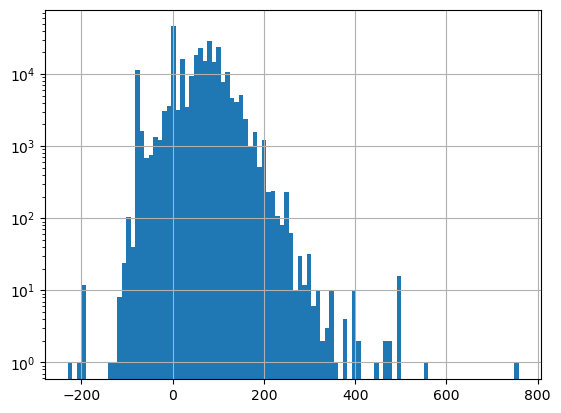

In [339]:
df.temp.hist(bins=100)
plt.yscale('log')

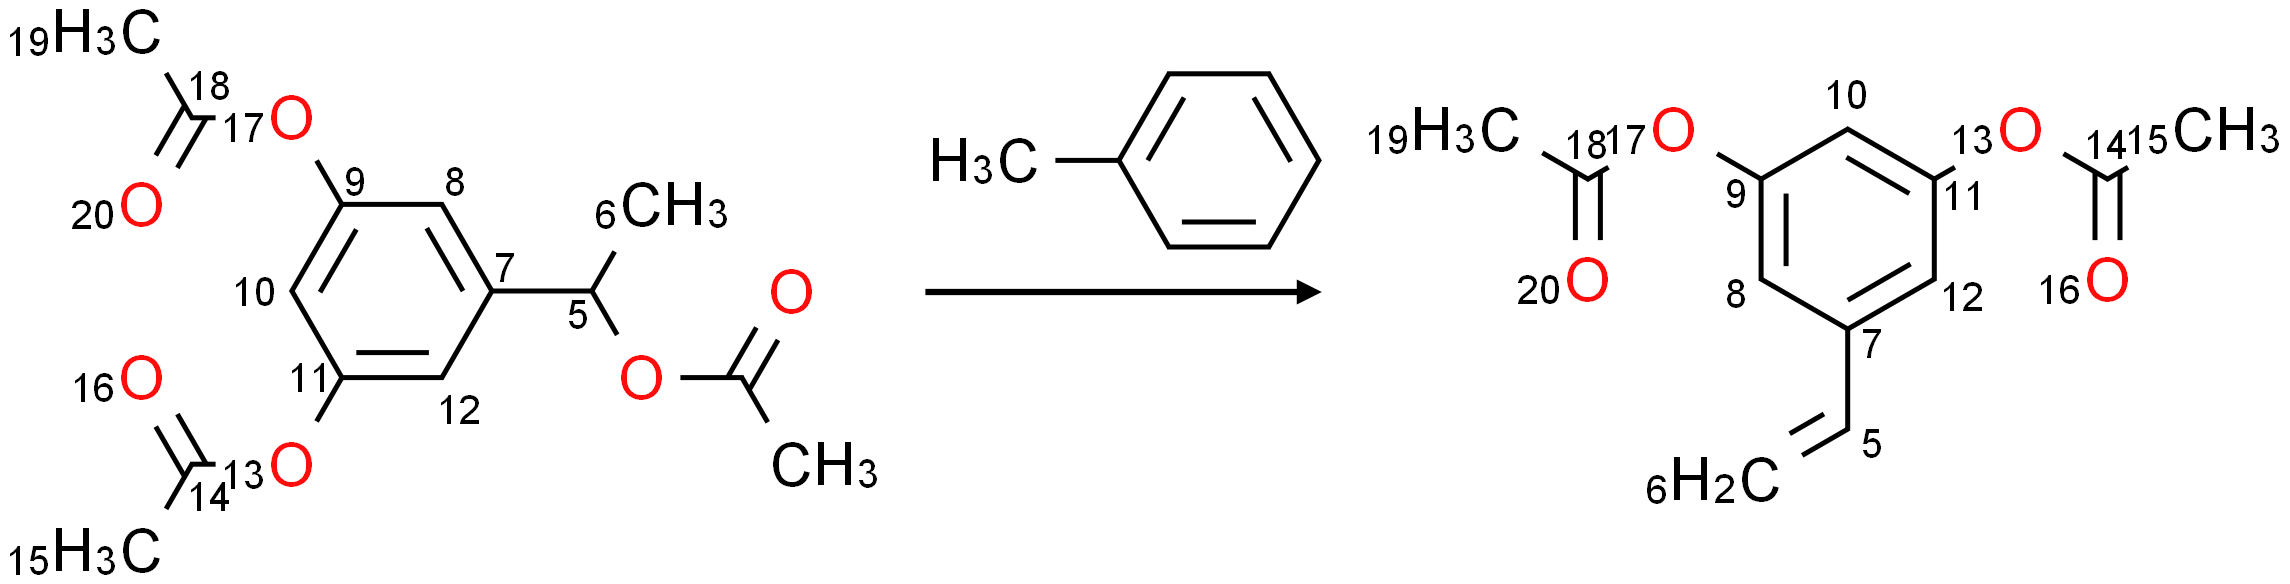

Set size:         36
Patent:           US07820848B2
Reaction_id:      ord-4384818e26ee41f096313884190b9ad7
20 g of 1-(1-acetoxyethyl)-3,5-diacetoxy-benzene (71 mmol) were dissolved in 20 ml toluene and placed into a feed vessel connected to a pyrolytic tube filled with Raschig rings. The tube was heated to 500° C. and the neat mixture was immediately added. Conversion of the alcohol was achieved within two minutes. The column was rinsed with toluene. Work-up was conducted by extracting the crude material in toluene twice with 200 ml water. The aqueous solutions were reextracted with toluene, the organic layers were combined, dried over magnesium sulfate and the solvent removed under reduced pressure giving 6.6 g 3,5-diacetoxystyrene (42%).


'ord-4384818e26ee41f096313884190b9ad7'

In [359]:
draw_reaction(df[df.temp > 380])

In [367]:
# keep only temp nan or  < 380°C
df = df[df.temp.isna() | (df.temp < 380)]

,rxn_smiles,time,temp,temp_control,yield,patent,notes,c_ratio
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...,0.750000
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...,0.780000
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...,0.727273
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ...",0.769231
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ...",0.779412
...,...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...,0.770642
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...,0.766355
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{...",0.785047
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{...",0.788991


In [412]:
df.loc[df.temp < -200]

,rxn_smiles,time,temp,temp_control,yield,patent,notes,c_ratio
ord-9989c8157da74452a4e0f0b2b520b6b2,[Cl:1][C:2]1[C:7]([F:8])=[CH:6][CH:5]=[C:4]([C...,NaN,-205.0,NaN,NaN,US08951993B2,"A mixture of 3-[1-(2,6-dichloro-3-fluoro-pheny...",0.705882


In [413]:
# quick fix of 2 mistakes
df.loc[df.temp == -230.0, 'temp'] = -23.0
df.loc[df.temp == -205, 'temp'] = 205

## 1.4 Filter by fraction of Carbon atom count

In [186]:
from chem_render import indigo

rxn_smi = df.loc['ord-e62a457d845a41ecb2e8d49c6375ba1d', 'rxn_smiles']

def carbon_ratio(rxn_smi: str) -> float:
    rxn = indigo.loadReaction(rxn_smi)
    carbon_count = 0
    total_count = 0
    for mol in rxn.iterateMolecules():
        for atom in mol.iterateAtoms():
            if atom.symbol() == 'C':
                carbon_count += 1
        total_count += mol.countAtoms()
    return carbon_count/total_count

print('carbon_ratio', carbon_ratio(rxn_smi))

carbon_ratio 0.8080808080808081


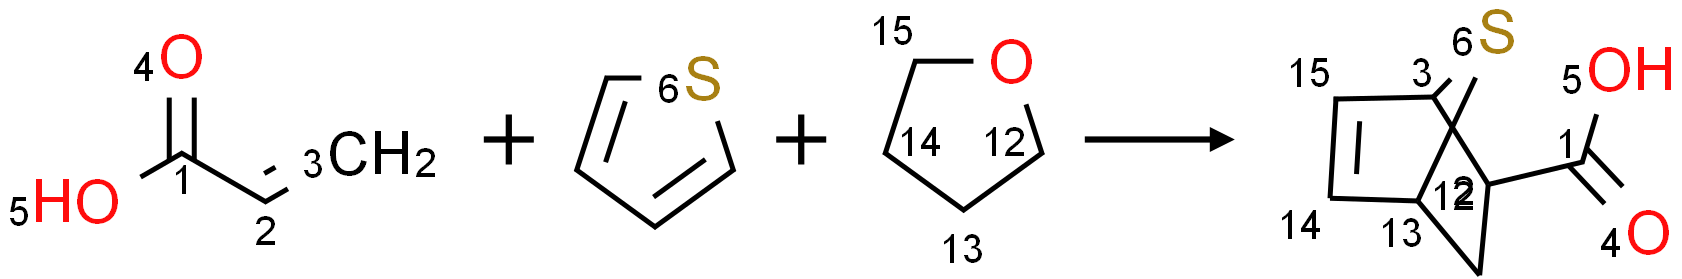

Set size:         52
Patent:           US06291131B1
Reaction_id:      ord-7cf5ee0f68e8485391384bd50723dcd8
Tetrahydrofuran solvent (500 g), acrylic acid (1.2 mole) and thiophene (1.0 mole) are introduced into a 2-liter flask. After stirring at 700° C. for 24 hours, the solvent and excessive acrylic acid are removed by using a rotary evaporator. The residue is distilled in vacuo to obtain pure 7-thiabicyclo[2.2.1]hept-5-ene-2-carboxylic acid of Chemical Formula 142 (yield: 80%).


0.72

In [193]:

carbon_ratio(df.loc[rxn_id, 'rxn_smiles'])

In [239]:
%%time
# df['c_ratio'][:1000] = df.rxn_smiles.apply(carbon_ratio)

c_ratio = df.rxn_smiles[:1000].apply(carbon_ratio)
c_ratio_approx = df.rxn_smiles[:1000].str.count(r'C(?![a-z])') / df.rxn_smiles[:1000].str.count(r'[A-GI-Z]')
# pd.concat([c_ratio, c_ratio_approx, (c_ratio - c_ratio_approx)/c_ratio > 0.01], axis=1)
any((c_ratio - c_ratio_approx)/c_ratio > 0.01)

CPU times: total: 1.11 s
Wall time: 1.11 s


False

In [415]:
%%time
c_ratio = df.rxn_smiles.str.count(r'C(?![a-z])') / df.rxn_smiles.str.count(r'[A-GI-Z]')

CPU times: total: 20.6 s
Wall time: 20.6 s


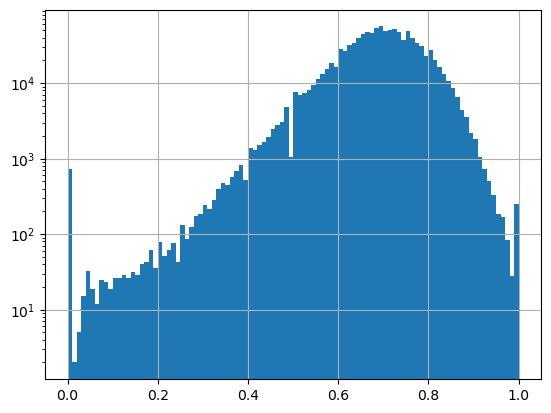

In [507]:
c_ratio.hist(bins=100)
plt.yscale('log')

In [508]:
# drop inorganic reactions
df = df[c_ratio > 0.0]

C:\Users\ergot\AppData\Local\Temp\ipykernel_14104\2961607638.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[c_ratio > 0.0]


C:\Users\ergot\AppData\Local\Temp\ipykernel_14104\865991295.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  draw_reaction(df[c_ratio.between(0.0, 0.3)])


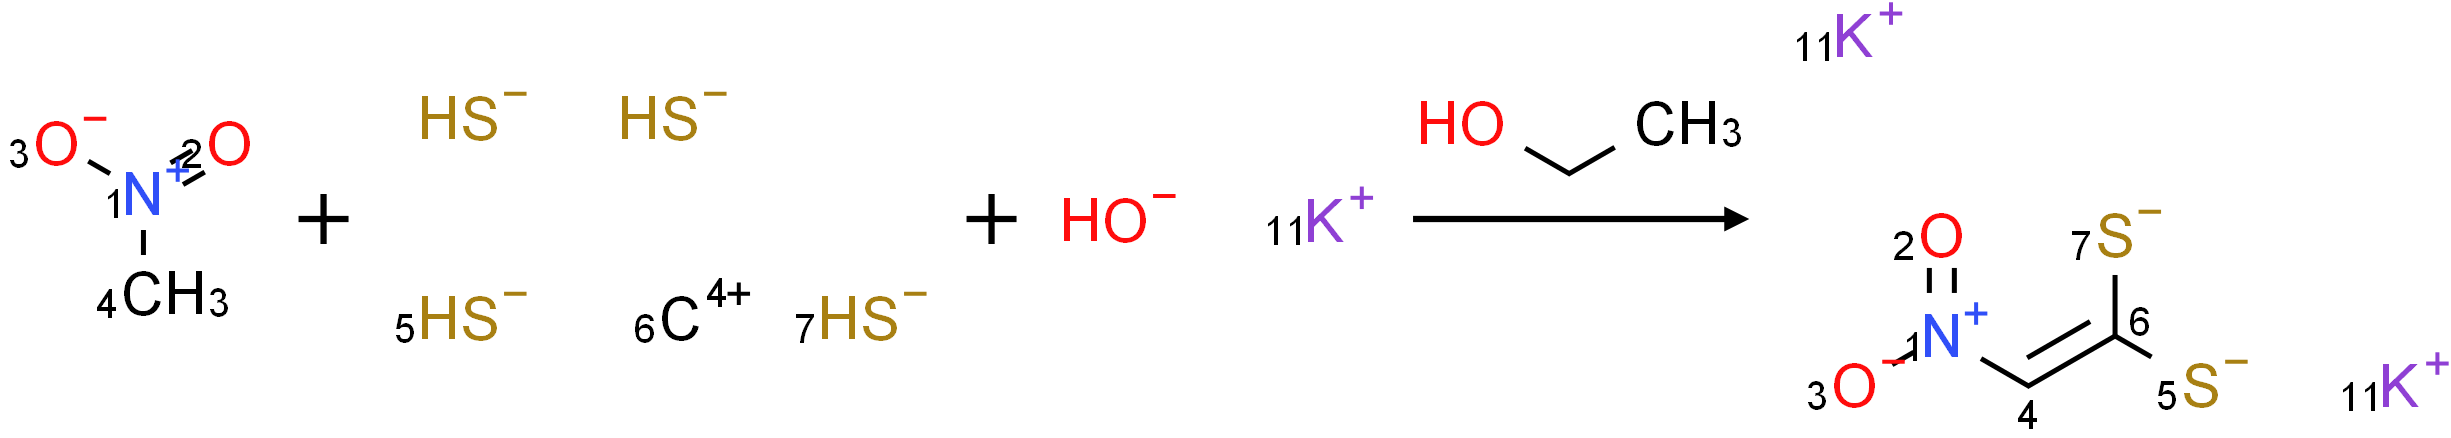

C:\Users\ergot\AppData\Local\Temp\ipykernel_14104\865991295.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[c_ratio > 0.3]


Set size:         1583
Patent:           US07655665B2
Reaction_id:      ord-76d08d585737439494ef9f84d0a64871
4 g (0.03 mol) of nitromethane and 6 ml (0.05 mol) of carbon bisulfide were placed in a 100 ml three-necked flask and 10 ml of ethanol was added as a solvent, and then the solution was stirred. To the resulting solution was added slowly and dropwise the solution of 8 g (0.14 mol) of potassium hydroxide in 40 ml of ethanol at room temperature over nearly 30 min. Since the reaction was exothermic, the rate of addition depended on the reaction temperature which was preferably between 30-35° C. After the addition was complete, the mixture was further stirred for 2 hours, filtered to obtain a crude product, which was a brown yellow powder in 72% yield.


In [505]:
# 0.3 seems to be a good threshold to drop reactions of no interest
draw_reaction(df[c_ratio.between(0.0, 0.3)])
df = df[c_ratio > 0.3]

C:\Users\ergot\AppData\Local\Temp\ipykernel_14104\1252439731.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  draw_reaction(df[c_ratio == 1.0])


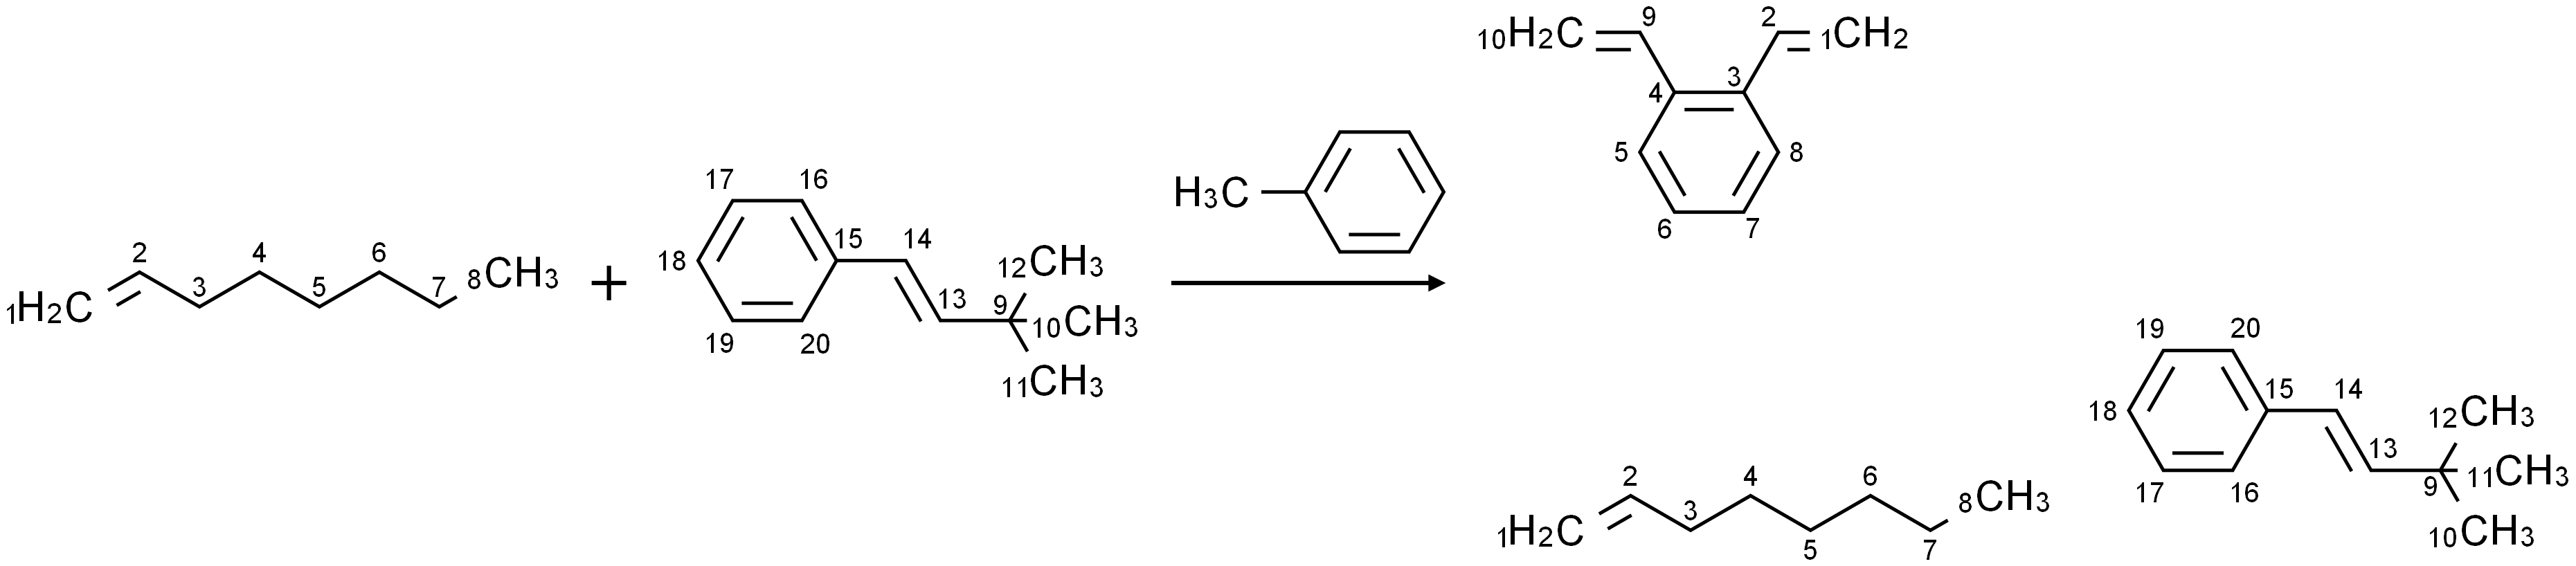

Set size:         251
Patent:           US09109057B2
Reaction_id:      ord-436597a392bb4bc08ca9aa3a8b13d267
The polymerization reaction was conducted in a 300 ml stainless autoclave equipped with a mechanical stirrer. In an argon filled dry-box, the reactor was charged with 50 ml of toluene, 0.2 ml of DVB, and various volume ratios of 1-octene and tert-butylstyrene (Oct/BSt=7/3, 6/4, 5/5, 6/4, and 7/3 ml). The reactor was then sealed and then moved from the dry box and purged with nitrogen gas at 30° C. About 0.101 g of TiCl3(AA) and 1 ml of AlCl2Et in 10 ml of toluene, after mixing for 20 minutes by stirring, were introduced to the reactor under nitrogen pressure to initiate the polymerization. After about 1 hour, the reaction was terminated by adding 100 ml of dilute HCl solution in methanol to the reactor. The 1-octene/t-butylstyrene/divinylbenzene terpolymers were isolated by filtration and washed completely with methanol and dried under vacuum for about 8 hours. The resulting terp

C:\Users\ergot\AppData\Local\Temp\ipykernel_14104\1252439731.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[c_ratio < 1.0]


In [491]:
# we can also safely drop hydrocarbon chemistry. It is not interesting for us
draw_reaction(df[c_ratio == 1.0])
df = df[c_ratio < 1.0]

In [6]:
# save results
df.to_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

# Inspect COMPOUNDS dataset

In [528]:
rxn = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

In [529]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_cmpd.pkl.zst")

CPU times: total: 6.31 s
Wall time: 6.32 s


In [530]:
%%time
# keep compounds from filtered reaction set
df = df.loc[rxn.index]

CPU times: total: 14.5 s
Wall time: 14.5 s


In [531]:
df

,trivial,name,smiles,rxn_role
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,4-octyloxybenzoic acid chloride,C(CCCCCCC)OC1=CC=C(C(=O)Cl)C=C1,8
ord-89aff4b1c18042e4bbb1f88ebba96f86,( 1 ),p-n-octyloxybenzoic acid,C(CCCCCCC)OC1=CC=C(C(=O)O)C=C1,1
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,p-octyloxybenzoic acid,C(CCCCCCC)OC1=CC=C(C(=O)O)C=C1,1
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,thionyl chloride,S(=O)(Cl)Cl,1
ord-c218088b16c541088a933a7606f68c4c,None,p-decanoyloxybenzoic acid,C(CCCCCCCCC)(=O)OC1=CC=C(C(=O)O)C=C1,8
...,...,...,...,...
ord-055170a7c2ee464ba733ada95c7896b8,None,"(1R,5S)-7-{4-[2-(2,6-Dichloro-4-methyl-phenoxy...",C1(CC1)N(C(=O)C=1[C@H]2CNC[C@@H](CC1C1=CC=C(C=...,8
ord-055170a7c2ee464ba733ada95c7896b8,None,cyclopropyl-[5-(3-methoxy-propyl)-2-methyl-ben...,C1(CC1)NCC1=C(C=CC(=C1)CCCOC)C,1
ord-50ff38288a5a4316959b81c266f6f624,None,"(1R,5S)-7-{4-[2-(2,6-Dichloro-4-methyl-phenoxy...",C1(CC1)N(C(=O)C=1[C@H]2CNC[C@@H](CC1C1=CC=C(C=...,8
ord-50ff38288a5a4316959b81c266f6f624,None,"(1R,5S)-7-{4-[2-(2,6-dichloro-4-methyl-phenoxy...",C(C)(C)(C)OC(=O)N1C[C@H]2CC(=C([C@@H](C1)N2C(=...,1


In [532]:
df_na_vals(df)

trivial       ->      Missing values: 5295810 (88.65%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 181879 (3.04%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

### inspect missing smiles

In [533]:
df[df.smiles.isna()].name.value_counts()

ice water                                   16943
ice                                         10592
aqueous solution                             6195
TEA                                          5461
hexanes                                      3968
                                            ...  
platinic chloride                               1
8-L                                             1
Tris(dibenzylideneacetone)palladium (0)         1
Tris (dibenzylideneacetone)palladium (0)        1
product ( IV )                                  1
Name: name, Length: 43240, dtype: int64

In [539]:
# REACTANT  1
# SOLVENT   3
# CATALYST  4
# WORKUP    5
# PRODUCT   8

df[df.smiles.isna() & (df.name == 'ice water')].rxn_role.value_counts()

1    15104
3     1837
4        1
8        1
Name: rxn_role, dtype: int64

In [541]:
idx = df[df.smiles.isna() & (df.name == 'ice water') & (df.rxn_role == 4)].index

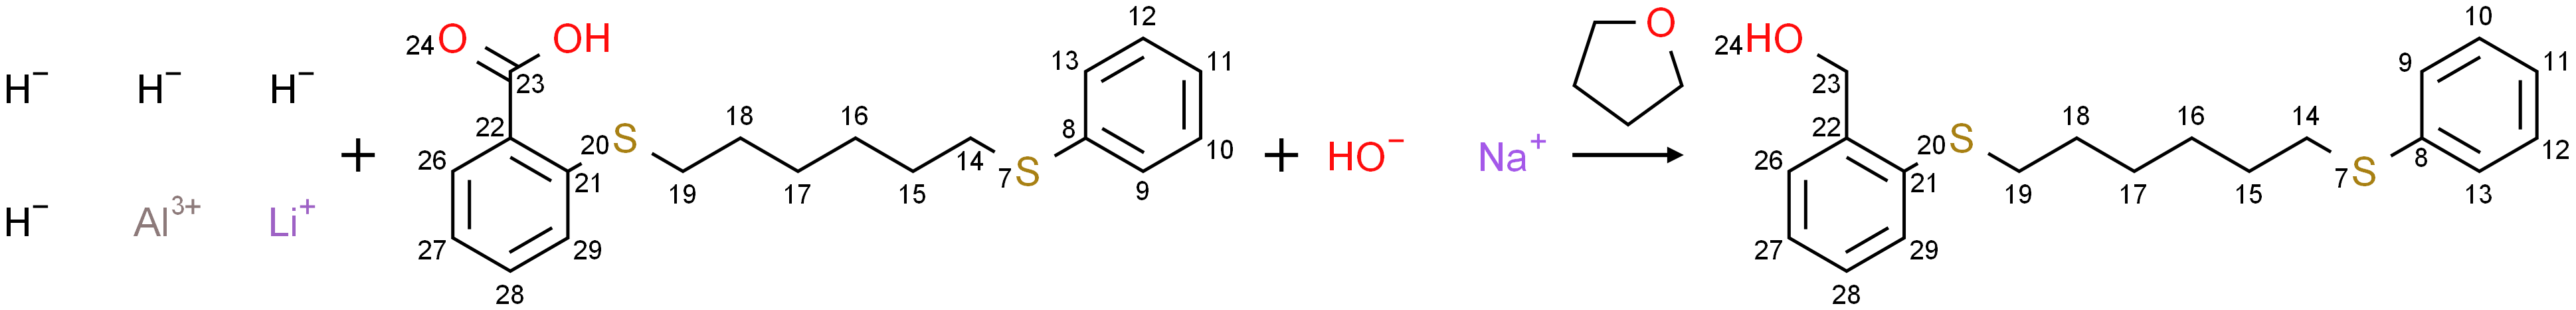

Set size:         1
Patent:           US05314918
Reaction_id:      ord-da7939a2978843b28f3e5a686a2e414c
To a suspension of lithium aluminum hydride (0.292 g, 0.007 mole) in tetrahydrofuran (30 ml) is added a solution of 2-(6-thiophenoxyhexylthio)benzoic acid (2.42 g, 0.007 mole) in tetrahydrofuran (30 ml). The reaction is stirred at room temperature under argon, overnight. When the reaction is complete several drops of ice water are added followed by cold 10% sodium hydroxide (approximately 1.0 ml), followed by cold 10% sodium hydroxide (approximately 1.0 ml), followed by more ice water. This produces a dry granular precipatate which is filtered and is washed. The filtrate is then dried over magnesium sulfate, filtered and is evaporated. The crude alcohol is flash chromatographed on silica gel to give the desired compound.


'ord-da7939a2978843b28f3e5a686a2e414c'

In [542]:
draw_reaction(rxn.loc[idx], highlight_text='ice water')

### Clean empty smiles
all non chemically-meaningful compounds, e.g. ```'solution', 'solid', 'resultant mixture', 'powder', 'crude material'```, with no smiles can be dropped. It is just parsing error. We keep 'ice water', 'ice', 'water' for the moment as it might indicate solvent or temperature.

In [543]:
empty_smi = df[df.smiles.isna()].name.value_counts()
empty_smi

ice water                                   16943
ice                                         10592
aqueous solution                             6195
TEA                                          5461
hexanes                                      3968
                                            ...  
platinic chloride                               1
8-L                                             1
Tris(dibenzylideneacetone)palladium (0)         1
Tris (dibenzylideneacetone)palladium (0)        1
product ( IV )                                  1
Name: name, Length: 43240, dtype: int64

In [544]:
q = 0.99
print(empty_smi[empty_smi > empty_smi.quantile(q)].sum() / empty_smi.sum())
token_list = empty_smi[empty_smi > empty_smi.quantile(q)]
token_list

0.5151281896205719


ice water                                                                        16943
ice                                                                              10592
aqueous solution                                                                  6195
TEA                                                                               5461
hexanes                                                                           3968
hydrochloride salt                                                                2092
amine                                                                             1827
ester                                                                             1464
acid chloride                                                                     1436
alcohol                                                                           1325
Grignard reagent                                                                  1077
petroleum ether                            

In [545]:
print(np.array2string(token_list.index.values, separator=',', max_line_width=10))

['ice water',
 'ice',
 'aqueous solution',
 'TEA',
 'hexanes',
 'hydrochloride salt',
 'amine',
 'ester',
 'acid chloride',
 'alcohol',
 'Grignard reagent',
 'petroleum ether',
 'polyphosphoric acid',
 'EtOAc hexanes',
 'hexanes ethyl acetate',
 'methyl ester',
 'aldehyde',
 'amide',
 'ethyl acetate hexanes',
 'cuprous iodide',
 'anhydride',
 'Ice water',
 'N,N-dimethylaminopyridine',
 'ketone',
 'acid',
 'cuprous chloride',
 'xylenes',
 'carboxylic acid',
 "N,N'-carbonyldiimidazole",
 'diazonium salt',
 'ethyl ester',
 'Mg',
 'resin',
 'IMS',
 'solvent',
 'tetrakistriphenylphosphine palladium',
 'CuBr',
 'stannous chloride',
 'imine',
 'base',
 'stannous chloride dihydrate',
 'N,N′-carbonyldiimidazole',
 'NaIO4',
 'dimethyl acetal',
 'ferric chloride',
 'cuprous cyanide',
 'hydrate',
 '4-N,N-dimethylaminopyridine',
 'NH4OAc',
 'Hexanes',
 'reduced iron',
 'peroxide',
 'Na',
 'water ice',
 'EtOAc-hexanes',
 'LiOH monohydrate',
 'monohydrate',
 'oxime',
 'nitrile',
 'NaH2PO4',
 'ice H2O

In [546]:
drop_list = [
            'solution',
            # 'ice water',
            'solid',
            # 'ice',
            'resultant mixture',
            # 'aqueous solution',
            # 'TEA',
            'crude product',
            # 'hexanes',
            'oil',
            'product',
            'resultant solution',
            # 'hydrochloride salt',
            'compound',
            # 'amine',
            'mixture',
            # 'acid chloride',
            # 'ester',
            # 'alcohol',
            # 'hexanes ethyl acetate',
            'powder',
            # 'polyphosphoric acid',
            # 'Grignard reagent',
            # 'EtOAc hexanes',
            # 'petroleum ether',
            'crude material',
            # 'amide',
            'foam',
            # 'methyl ester',
            # 'EtOAc-hexanes',
            # 'ethyl acetate hexanes',
            # 'aldehyde',
            '4A',
            # 'cuprous iodide',
            'stainless steel',
            'material',
            'crystals',
            'crude mixture',
            'liquid',
            'suspension',
            'catalyst',
            'three',
            # 'anhydride',
            'title compound',
            'resultant suspension',
            'SiO2',
            # 'Ice water',
            # 'ketone',
            # 'N,N-dimethylaminopyridine',
            '( a )',
            # 'dimethyl acetal',
            # 'cuprous chloride',
            '( 1 )',
            'steel',
            'residue',
            # 'xylenes',
            # 'acid',
            'desired product',
            '( 100 )',
            # 'diazonium salt',
            'white solid',
            # 'carboxylic acid',
            # 'ethyl ester',
            '3A',
            '( 2 )',
            # 'resin',
            'Teflon',
            # 'base',
            'crude residue',
            # 'IMS',
            'II',
            '10',
            '( m )',
            'raw materials',
            # 'stannous chloride dihydrate',
            # 'imine',
            # "N,N'-carbonyldiimidazole",
            'saturated aqueous solution',
            '( 3 )',
            # 'Hexanes',
            # 'stannous chloride',
            'saturated solution',
            # 'solvent',
            '( b )',
            '( 5 )',
            # 'tetrakistriphenylphosphine palladium',
            # 'Mg',
            # 'CuBr',
            '( s )',
            # 'NaIO4',
            '3','1',
            'glass',
            'intermediate',
            # 'cuprous cyanide',
            # 'hydrate',
            # '4-N,N-dimethylaminopyridine',
            # 'peroxide',
            '( 4 )',
            # 'N,N′-carbonyldiimidazole',
            # 'NH4OAc',
            # 'ferric chloride',
            # 'Na',
            # 'ice H2O',
            # 'N-Aryl-benzenesulfonamides',
            # 'water ice',
            # 'hexanes EtOAc',
            '( c )',
            # 'NaH2PO4',
            'reagent',
            'gum',
            '2','20',
            'teflon',
            # 'nitrile',
            # 'alkyne',
            # 'reduced iron',
            # 'oxime',
            # 'monohydrate',
            '( g )',
            '( w )',
            # 'diol',
            'Intermediate 1',
            'starting material',
            # 'fumarate salt',
            'Heterocyclic',
            # 'EtOAc Hexanes',
            # 'stannic chloride',
            # 'nitro',
            # 'mercuric chloride',
            # 'esters',
            '( I )',
            # 'KHCO3',
            # 'LiOH monohydrate',
            # 'polystyrene',
            'yellow solid',
            '( A )',
            'solids',
            # 'amides',
            '15',
            '( 6 )',
            # 'Na2S2O5',
            # 'mercuric acetate',
            'final mixture',
            # 'Ice',
            # 'amino acid',
            '( d )',
            # 'FeCl3',
            # 'ice-salt',
            # 'tetrakis(triphenyl-phosphine)palladium',
            # 'cuprous bromide',
            '50',
            'paraffin',
            # 'epoxide',
            # 'diamine',
            # 'triethylamine-2HF',
            # '1,1-carbonyldiimidazole',
            '( 8 )',
            # 'ethanolic solution',
            # 'mercuric oxide',
            'III',
            'raw material',
            '( 9 )',
            '12',
            'desired material',
            # 'methanolic solution',
            # 'PdCl2dppf',
            # 'peptide',
            'title compounds',
            'salt',
            # 'palladium tetrakistriphenylphosphine',
            '1-L',
            'free base',
            '( 7 )',
            '30',
            # 'diazonium',
            # 'acetate salt',
            # 'diethyl ester',
            '10/1',
            # 'potassium tert.-butylate',
            # 'olefin',
            'Intermediate 2',
            # 'CsCO3',
            'crystal',
            'one',
            # 'cuprous oxide',
            # 'sulfonamide',
            '( 10 )',
            # 'secondary amine',
            'Example 1',
            'two',
            '4',
            'eluent',
            # 'N,N-dicyclohexylcarbodiimide',
            # 'ethyl acetate petroleum ether',
            # 'ceric ammonium nitrate',
            '40',
            # 'Amine',
            'Compound II',
            '( B )',
            # 'CrO3',
            '100',
            # 'thiol',
            # 'cupric acetate',
            'complex',
            # 'petroleum ether ethyl acetate',
            'IV',
            'atmosphere',
            '2-L',
            # 'amines',
            # 'oxide',
            'step-ii',
            'four',
            'E1',
            'desired compound',
            # 'acyl chloride',
            '( II )',
            'crude compound',
            # 'triethyl phosphonoacetate',
            'resultant product',
            'Heterocycles',
            # 'CuSO4.5H2O',
            # 'ethylene ketal',
            'Intermediate 6',
            'crude intermediate',
            # 'ethyl acetate-hexanes',
            # 'acetal',
            'solution A',
            # 'ammonium salt',
            # 'aq. solution',
            # 'oxalate salt',
            # '2B',
            # '5,6-dihydrospiro[benzo[1,2-b:5,4-b′]difuran-3,3′-indol]-2″(1′H)-one',
            # 'Cu',
            # 'alcohols',
            '1h',
            # 'ice hydrochloric acid',
            # 'tertiary amine',
            'desired intermediate',
            '1a',
            # 'heptanes',
            # 'ferrous sulfate',
            # 'Hexanes EtOAc',
            '( 15 )',
            '9',
            # 'cupric chloride',
            'ArH',
            '11',
            # 'pinacol ester',
            '21',
            'title material',
            # 'Pd(Ph3)4',
            'D4',
            'Intermediate 4',
            'amino',
            # 'tetrakistriphenylphosphine palladium(0)',
            'DNA',
            '60',
            # 'diethyl acetal',
            'compound 1',
            # 'SeO2',
            # 'Cu2O',
            # 'industrial methylated spirit',
            'mixed solvent',
            'dihydrobromide',
            # 'tetrakistriphenylphosphine palladium (0)',
            'crude solution',
            # 'amino acids',
            # 'TiCl3',
            'pure product',
            'Intermediate 14',
            'PTFE',
            '2h',
            # 'HClO4',
            'A1',
            '( 12 )',
            # 'Na2HPO4',
            # 'dioxanes',
            # 'sulfonic acid',
            # 'di-TFA',
            'white crystals',
            'E2',
            'trihydrochloride',
            # 'CuCl2',
            'polymer',
            'formula II',
            '1L',
            # 'Boc',
            '13',
            'stock solution',
            # 'CeCl3',
            # 'carboxylic acids',
            # 'H+',
            # 'TBF',
            # 'Ag2O',
            # 'CO3',
            'R3—(CH2)m—NH2',
            '( 11 )',
            # 'Petroleum ether',
            'intermediate 27',
            # 'SO2Cl2',
            '1E',
            '( i )',
            '( C )',
            '25',
            'Solution A',
            'mixed solution',
            'hydrobromide salt',
            '14',
            'resultant residue',
            'Amine-1',
            'Intermediate 12',
            'bromo',
            # 'potassium t-butylate',
            'needles',
            'Intermediate 5',
            # 'enolate',
            # 'carbonyl',
            # 'Pt',
            # 'SnCl2 dihydrate',
            'quartz',
            # 'tetrakis-(triphenylphosphine)palladium',
            'Intermediate 3',
            '5-L',
            'example 1 ( b )',
            '( E )-',
            # 'hydrocarbon',
            # 'ice methanol',
            # 'ferric chloride hexahydrate',
            # 'diacid',
            # 'halogen',
            # 'crude acid',
            '18',
            'same solvent',
            'C2',
            'molar solution',
            'starch',
            '( 20 )',
            '17',
            # 'hydrazone',
            # 'Ti(OEt)4',
            '( ii )',
            # 'K3PO4.3H2O',
            '( 1H )',
            '0C',
            # 'Pd[PPh3]4',
            # 'ferrous chloride tetrahydrate',
            'chloro',
            # 'tetrakis (triphenylphosphine)palladium(0)',
            '( M )',
            # 'alkoxide',
            '1-a',
            # 'pyridinium bromide perbromide',
            '( 14 )',
            # 'magnesium salt',
            '2L',
            'target compound',
            'orange oil',
            'final product',
            'intermediate 1',
            '2A',
            '( III )',
            # 'Cu(I)I',
            # 'FeSO4.7H2O',
            '2C',
            # 'tetrakis triphenylphosphine palladium',
            'Formula III',
            '1/1',
            '200',
            'D1',
            'colorless oil',
            'diazo',
            'formula III',
            # 'PdC',
            # 'Pd--C',
            # 'polyester',
            # 'lactone',
            'VI','5',
            # 'hydrazide',
            # 'Na2SO4.10H2O',
            # 'glycol',
            'Solvent B',
            # 'primary amine',
            # 'NaHB(OAc)3',
            '6',
            '( 13 )',
            'Intermediate 7',
            'buffer solution',
            # 'N-oxide',
            '1A',
            # 'potassium osmate dihydrate',
            '( 18 )',
            '( 16 )',
            # 'halide',
            # 'diester',
            # 'zeolite',
            # 'ice acetone',
            'Intermediate 100',
            # 'hexanes ether',
            # 'carbamates',
            # 'ether-hexane',
            # 'petroleum ether EtOAc',
            'beige solid',
            # 'PdCl2(dppf)-CH2Cl2Adduct',
            # 'Amide',
            # 'sulfuric acid ester',
            # 'PdCl2(dppf)CH2Cl2',
            # 'Hastelloy',
            '( 19 )',
            'yellow oil',
            # 'ammonium sulfide',
            # 'azoisobutyronitrile',
            'Example 1 ( i )',
            # 'butyl ester',
            'final solution',
            '3h',
            'Intermediate 9',
            'syrup',
            '16',
            'compound 5',
            '3R',
            'crude oil',
            '2-N',
            'ion',
            # 'dihydrate',
            'Example 1 ( a )',
            '( E )',
            # 'polyethylene glycol',
            # 'RuCl3',
            # 'dimethyl ester',
            # '2-Me THF',
            'reaction mixture',
            # 'tetrakis(triphenyl-phosphine)palladium(0)',
            # 'Aqueous solution',
            # 'ferrous sulfate heptahydrate',
            'tricyclic bromide',
            # '4-nitrophenylchloroformate',
            '70',
            '5a',
            # 'acyloxyalkyl carbamates',
            'polyol',
            # 'hemihydrate',
            # 'aqueous saturated solution',
            # 'ether hexanes',
            # 'Ba(OH)2',
            # 'dichlorobis(triphenylphosphine) palladium (II)',
            # 'sulfone',
            '( D )',
            # "N,N'-Carbonyldiimidazole",
            # 'ion-exchanged',
            'alkyl',
            '1c',
            # 'ice NaCl',
            # 'enamine',
            # 'dimaleate',
            'off-white solid',
            '3-L',
            # 'EtOAc petroleum ether'
]

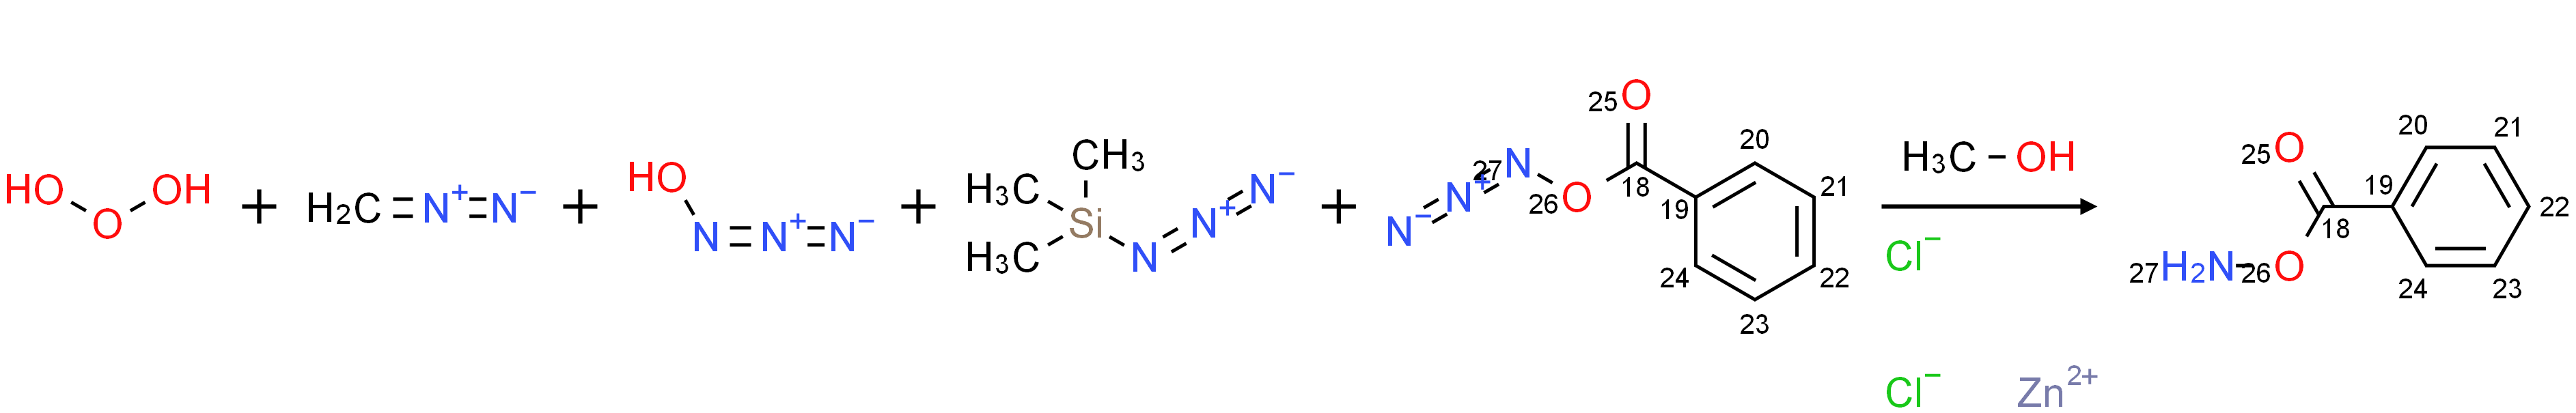

Set size:         55
Patent:           US05294737
Reaction_id:      ord-b96380cebd754560b1493c7a3b2468df
Phenylacetylene is subject to 1) hydroxymethylation followed by 2) Lindlar reduction to yield cis-cinnamyl alcohol. ##STR6## 3) The cis-cinnamyl alcohol is subjected to the titanium-catalyzed epoxidation process to yield (2S,3R)-epoxy alcohol. ##STR7## 4) This epoxy alcohol is oxidized with RuCl3 and NaIO4, and 5) the reaction product converted to the methyl ester of the epoxide with ethereal diazomethane. 6) This methyl ester of the epoxide is transformed into the desired hydroxyazide by epoxide cleavage using azidotrimethylsilane and a catalytic amount of zinc chloride followed by acid hydrolysis. ##STR8## 7) The hydroxy azide is transformed into azido benzoate and hydrogenated in methanol to produce amino benzoate. 8) The amino benzoate is rearranged to give the product. ##STR9## Modifications in this method have also been described by Denis, J. N. et al., "An Improved Synthesis 

'ord-b96380cebd754560b1493c7a3b2468df'

In [547]:
token = 'RuCl3'
idx = df[df.smiles.isna() & (df.name == token)].index
draw_reaction(rxn.loc[idx], highlight_text=token)

In [548]:
drop_list

['solution',
 'solid',
 'resultant mixture',
 'crude product',
 'oil',
 'product',
 'resultant solution',
 'compound',
 'mixture',
 'powder',
 'crude material',
 'foam',
 '4A',
 'stainless steel',
 'material',
 'crystals',
 'crude mixture',
 'liquid',
 'suspension',
 'catalyst',
 'three',
 'title compound',
 'resultant suspension',
 'SiO2',
 '( a )',
 '( 1 )',
 'steel',
 'residue',
 'desired product',
 '( 100 )',
 'white solid',
 '3A',
 '( 2 )',
 'Teflon',
 'crude residue',
 'II',
 '10',
 '( m )',
 'raw materials',
 'saturated aqueous solution',
 '( 3 )',
 'saturated solution',
 '( b )',
 '( 5 )',
 '( s )',
 '3',
 '1',
 'glass',
 'intermediate',
 '( 4 )',
 '( c )',
 'reagent',
 'gum',
 '2',
 '20',
 'teflon',
 '( g )',
 '( w )',
 'Intermediate 1',
 'starting material',
 'Heterocyclic',
 '( I )',
 'yellow solid',
 '( A )',
 'solids',
 '15',
 '( 6 )',
 'final mixture',
 '( d )',
 '50',
 'paraffin',
 '( 8 )',
 'III',
 'raw material',
 '( 9 )',
 '12',
 'desired material',
 'title compounds'

In [549]:
%%time
mask = ~df.name.isin(drop_list)
mask.sum()

CPU times: total: 984 ms
Wall time: 973 ms


5974025

In [550]:
%%time
df = df[mask]

CPU times: total: 1.3 s
Wall time: 1.29 s


In [551]:
df_na_vals(df)

trivial       ->      Missing values: 5295810 (88.65%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 181879 (3.04%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

In [552]:
# save cleaned version
df.to_pickle(f'{ORD_PATH}/uspto_cmpd.pkl.zst')

Total occurencies: 4


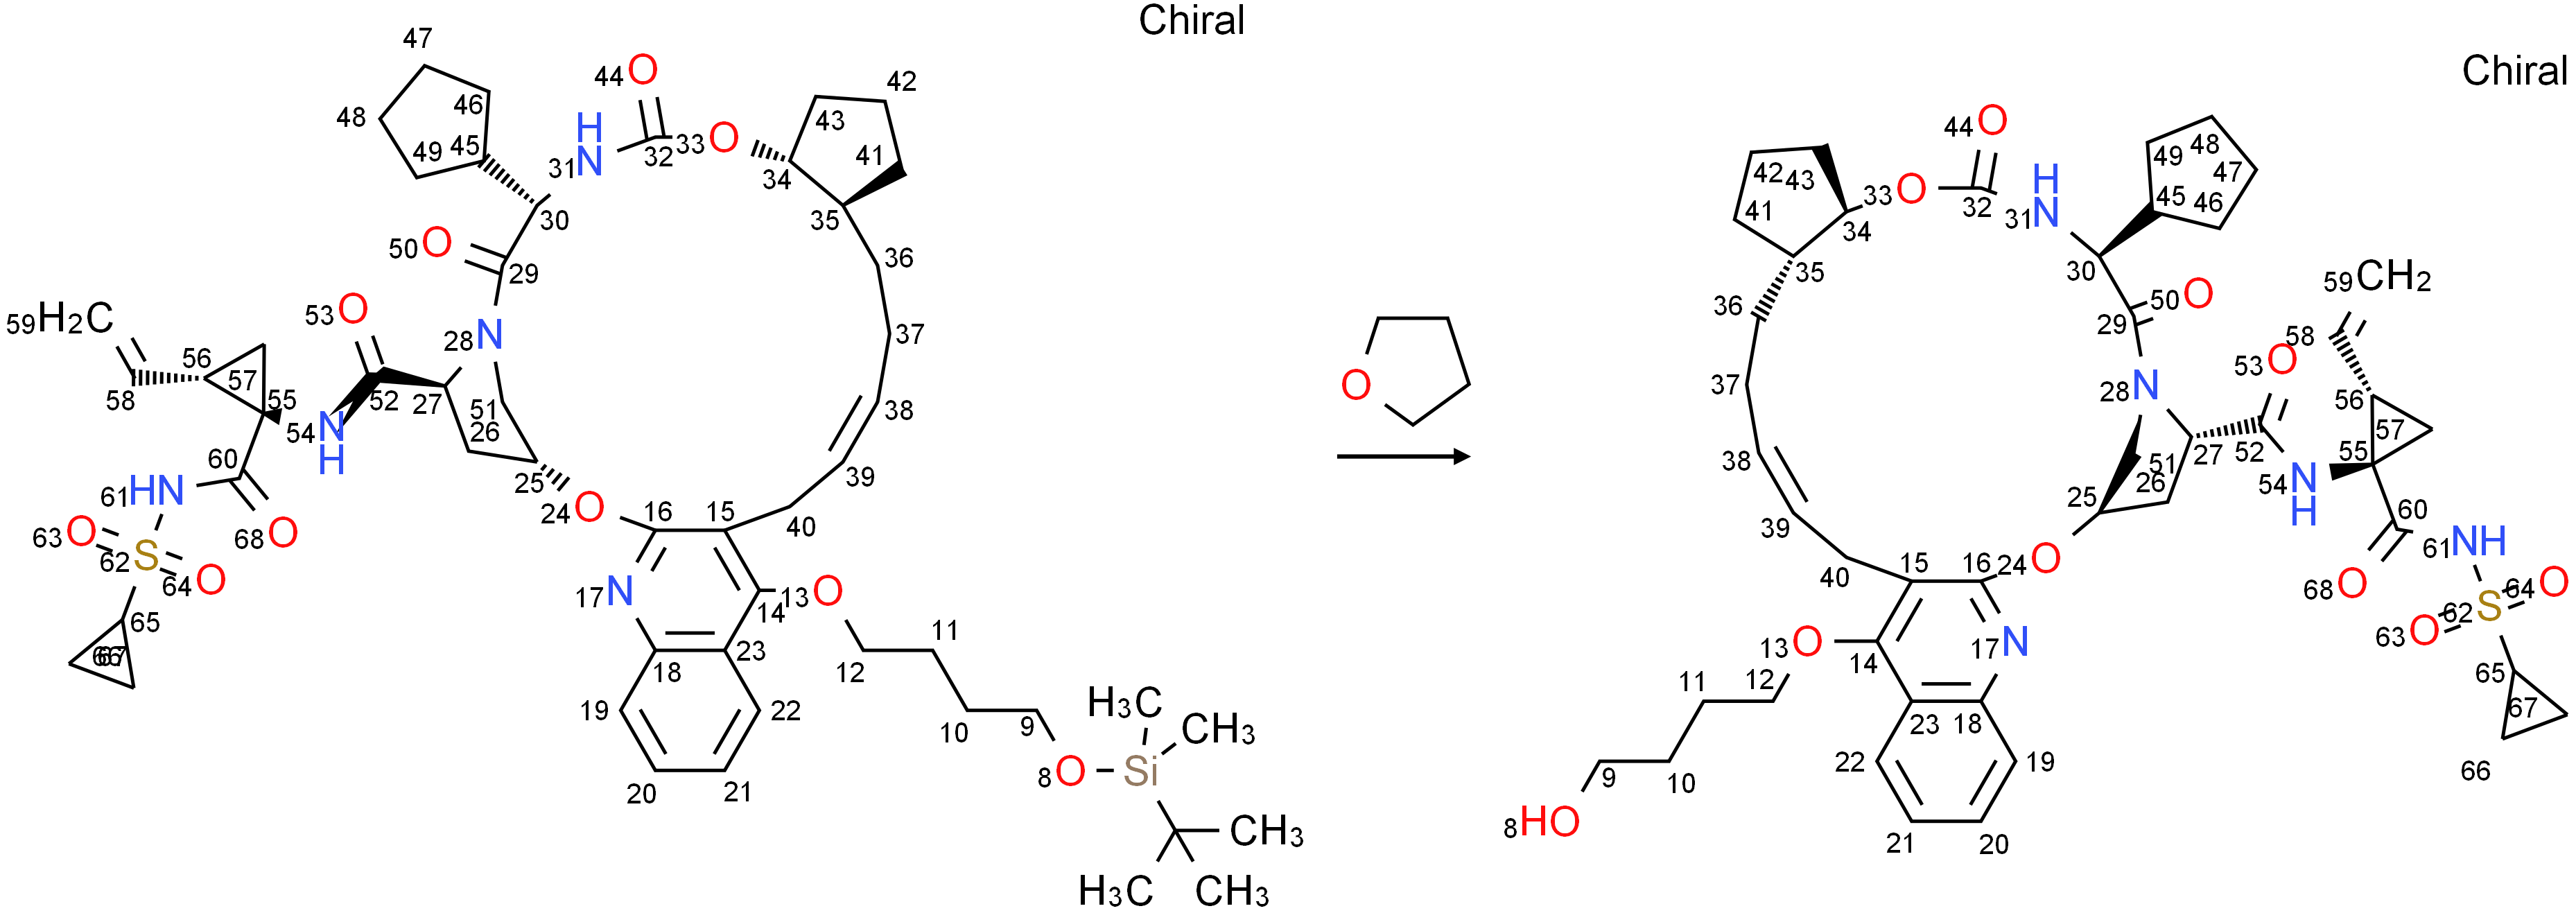

Set size:         4
Patent:           US09328138B2
Reaction_id:      ord-1bfa5e7874e94fe28d0dc25408df12ac
To a solution of the product of Step 1 (50 mg) in THF (0.5 mL) was added HF-TEA (0.334 mL) at room temperature. The solution was heated to 50° C. for 30 minutes. The reaction mixture was concentrated to remove THF and then diluted with EtOAc (10 mL) and water was added (10 mL). To that mixture was added Na2CO3 (353 mg) portion wise at 0° C. When the quench was complete, the layers were separated. The organic layer was washed with 10% Na2CO3, water and brine. The aqueous layer was re-extracted with ethyl acetate (2×). The combined organics were dried over magnesium sulfate, filtered and concentrated. Purification by reverse phase HPLC (40-100% ACN/water with 0.15% TFA) afforded the desired product (7.2 mg) after workup with NaHCO3 and ethyl acetate. HRMS (ES+) m/z 862.4073 (M+H)+.


'ord-1bfa5e7874e94fe28d0dc25408df12ac'

In [553]:
#TODO fix 'HF-TEA' token interpreted as 'TEA' only
idx = rxn.notes.str.contains(' HF-TEA')
print("Total occurencies:", idx.sum())
draw_reaction(rxn.loc[idx], highlight_text='HF-TEA')